<a href="https://colab.research.google.com/github/alwaysneedhelp/AI-Challenge/blob/main/AI_Challenge_1(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Load Data and Import Needed Libraries***

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from xgboost import XGBClassifier
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AI_Challenge_1_train.csv')
orig_df = df
for name in df.columns:
  df[name] = df[name].apply(
      lambda x: "No" if str(x).startswith("No") else x
  )


# ***Preprocess data***

In [ ]:
def preprocess(df):
  def filling_missed(df):
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
    import numpy as np

    df = df.replace(r'^\s*$', np.nan, regex=True)
    num_cols = df.select_dtypes(include=np.number).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    cat_cols = df.select_dtypes(include='object').columns
    df[cat_cols] = df[cat_cols].apply(lambda col: col.fillna(col.mode()[0]))

    return df


  def classifying(df):
    classing = [x for x in df.columns if df[x].dtype == object]
    for each in classing:
      if each in df.columns:
        df[each] = df[each].astype('category').cat.codes
    return df


  def new_features(df):
    df['isnew'] = (df['tenure']<6).astype(int)
    df['high_monthly'] = (df['MonthlyCharges']>df['MonthlyCharges'].median()).astype(int)

    df["Internet_OnlineSec_code"] = pd.factorize(
        df["InternetService"].astype(str) + "_" + df["OnlineSecurity"].astype(str)
    )[0]
    df['Electronic_check'] = (df['PaymentMethod']==2).astype(int)
    df['no_protection'] = ((df['OnlineSecurity']==0) & (df['TechSupport']==0)).astype(int)

    return df

  df = new_features(classifying(filling_missed(df)))

  return df


df = preprocess(df)


In [ ]:
df.columns

Index(['id', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'isnew', 'high_monthly',
       'Internet_OnlineSec_code', 'Electronic_check', 'no_protection'],
      dtype='object')

In [ ]:
df

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,isnew,high_monthly,Internet_OnlineSec_code,Electronic_check,no_protection
0,1162,1,0,0,1,1,0,0,0,0,...,1,3,31.35,31.35,1,1,0,0,0,1
1,2143,0,0,0,1,21,1,0,0,1,...,0,3,64.85,1336.80,0,0,0,1,0,0
2,1624,0,0,0,0,54,1,1,1,0,...,1,0,97.20,5129.45,0,0,1,2,0,1
3,6075,1,0,1,0,1,0,0,0,0,...,1,2,23.45,23.45,1,1,0,0,1,1
4,1363,1,0,0,0,4,1,0,1,0,...,1,2,70.20,237.95,1,1,0,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5630,3773,1,0,1,0,1,1,0,1,1,...,1,2,95.00,95.00,1,1,1,4,1,0
5631,5192,0,0,1,1,23,1,1,0,1,...,1,1,91.10,2198.30,0,0,1,1,0,0
5632,5227,1,0,1,1,12,1,0,2,0,...,1,2,21.15,306.05,0,0,0,3,1,1
5633,5391,1,1,0,0,12,1,1,1,0,...,1,2,99.45,1200.15,1,0,1,2,1,1


# ***Visualization***

In [ ]:
orig_df

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1162,Male,0,No,Yes,1,No,No,DSL,No,Yes,No,No,No,No,Yes,Mailed check,31.35,31.35,Yes
1,2143,Female,0,No,Yes,21,Yes,No,DSL,Yes,No,Yes,No,No,Yes,No,Mailed check,64.85,1336.80,No
2,1624,Female,0,No,No,54,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Yes,Bank transfer (automatic),97.20,5129.45,No
3,6075,Male,0,Yes,No,1,No,No,DSL,No,No,No,No,No,No,Yes,Electronic check,23.45,23.45,Yes
4,1363,Male,0,No,No,4,Yes,No,Fiber optic,No,No,No,No,No,No,Yes,Electronic check,70.20,237.95,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5630,3773,Male,0,Yes,No,1,Yes,No,Fiber optic,Yes,No,No,No,Yes,Yes,Yes,Electronic check,95.00,95.00,Yes
5631,5192,Female,0,Yes,Yes,23,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Credit card (automatic),91.10,2198.30,No
5632,5227,Male,0,Yes,Yes,12,Yes,No,No,No,No,No,No,No,No,Yes,Electronic check,21.15,306.05,No
5633,5391,Male,1,No,No,12,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,Electronic check,99.45,1200.15,Yes


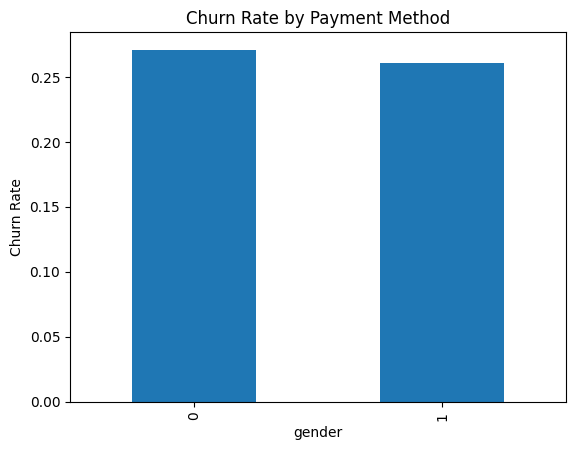

In [ ]:
# group by OnlineSecurity and calculate churn rate
churn_rate = df.groupby("gender")["Churn"].mean()


churn_rate.plot(kind="bar")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Payment Method")
plt.show()

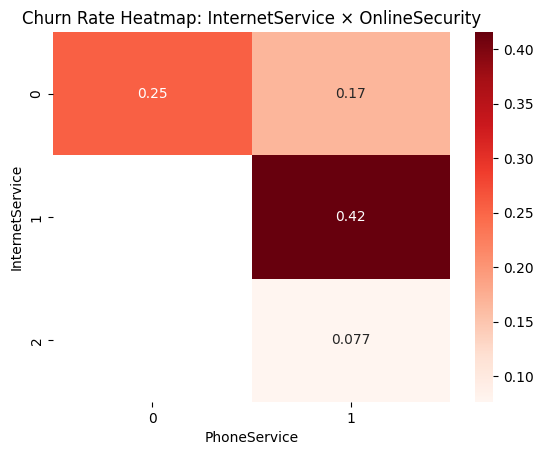

In [ ]:
import seaborn as sns

pivot = df.pivot_table(values="Churn",
                       index="InternetService",
                       columns="PhoneService",
                       aggfunc="mean")

sns.heatmap(pivot, annot=True, cmap="Reds")
plt.title("Churn Rate Heatmap: InternetService × OnlineSecurity")
plt.show()

In [ ]:
df

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,isnew,high_monthly,Internet_OnlineSec_code,Electronic_check,no_protection
0,1162,1,0,0,1,1,0,0,0,0,...,1,3,31.35,31.35,1,1,0,0,0,1
1,2143,0,0,0,1,21,1,0,0,1,...,0,3,64.85,1336.80,0,0,0,1,0,0
2,1624,0,0,0,0,54,1,1,1,0,...,1,0,97.20,5129.45,0,0,1,2,0,1
3,6075,1,0,1,0,1,0,0,0,0,...,1,2,23.45,23.45,1,1,0,0,1,1
4,1363,1,0,0,0,4,1,0,1,0,...,1,2,70.20,237.95,1,1,0,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5630,3773,1,0,1,0,1,1,0,1,1,...,1,2,95.00,95.00,1,1,1,4,1,0
5631,5192,0,0,1,1,23,1,1,0,1,...,1,1,91.10,2198.30,0,0,1,1,0,0
5632,5227,1,0,1,1,12,1,0,2,0,...,1,2,21.15,306.05,0,0,0,3,1,1
5633,5391,1,1,0,0,12,1,1,1,0,...,1,2,99.45,1200.15,1,0,1,2,1,1


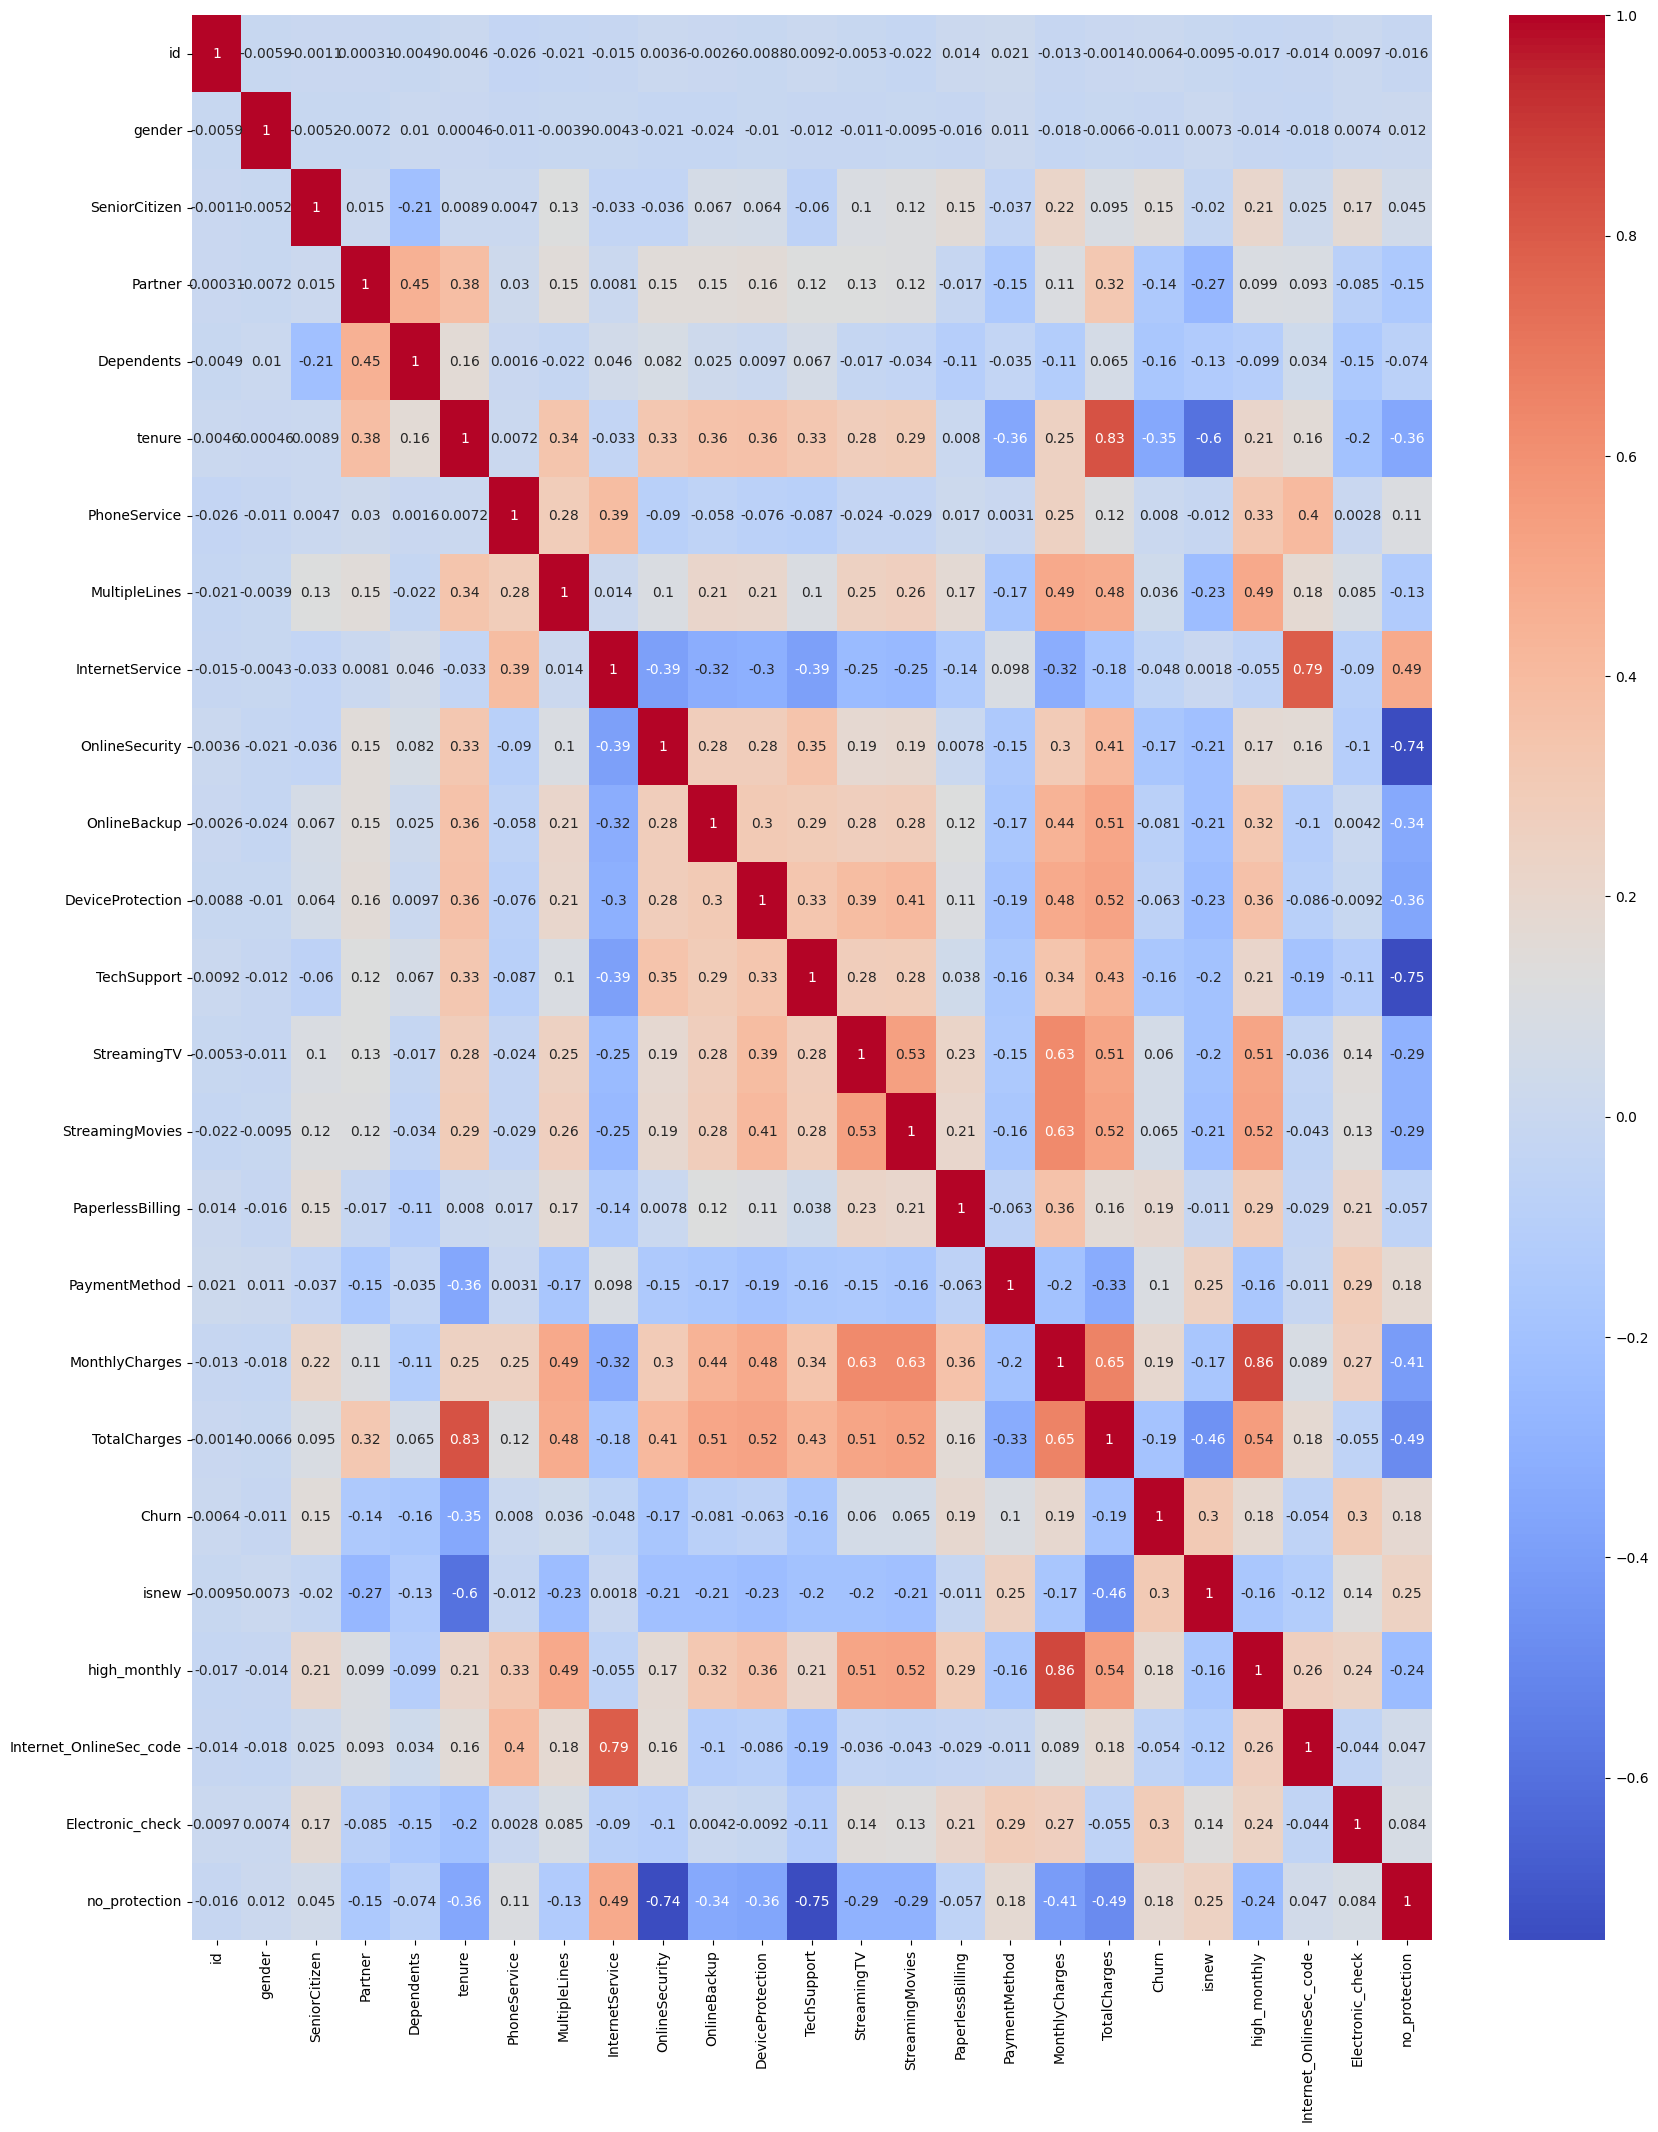

In [ ]:
plt.figure(figsize=(20,25))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

# ***Train the model***

In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = XGBClassifier(
    random_state=42,
    n_jobs=-1,
)

param_grid = {
    "n_estimators": [100, 300],       # fewer options
    "max_depth": [20, 40],          # shallow vs deep
    "min_samples_split": [2, 5],      # typical values
    "min_samples_leaf": [1, 2],       # small set
    "max_features": ["sqrt", "log2"], # drop the float
    "bootstrap": [True],              # keep one option
    "class_weight": ["balanced"]      # assume imbalance
}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="f1_weighted",
    cv=skf,
    n_jobs=-1,
    verbose=1
)

grid.fit(x_train, y_train)

print("Best weighted-F1 (CV):", grid.best_score_)
print("Best params:", grid.best_params_)

best_model = grid.best_estimator_


Fitting 5 folds for each of 32 candidates, totalling 160 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:27:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap", "class_weight", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best weighted-F1 (CV): 0.7606313267851812
Best params: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
importances = {}
for i in range(len(best_model.feature_importances_)):
  importances[df.columns[i]] = float(best_model.feature_importances_[i]*100)


importances

{'id': 2.5167417526245117,
 'gender': 2.30159330368042,
 'SeniorCitizen': 2.5912606716156006,
 'Partner': 2.2403674125671387,
 'Dependents': 3.095059394836426,
 'tenure': 6.954010009765625,
 'PhoneService': 2.165783166885376,
 'MultipleLines': 3.1702470779418945,
 'InternetService': 24.080238342285156,
 'OnlineSecurity': 2.668879985809326,
 'OnlineBackup': 2.90863299369812,
 'DeviceProtection': 3.208092212677002,
 'TechSupport': 4.543063640594482,
 'StreamingTV': 2.6129369735717773,
 'StreamingMovies': 2.6668314933776855,
 'PaperlessBilling': 3.710817813873291,
 'PaymentMethod': 2.6477370262145996,
 'MonthlyCharges': 3.482712507247925,
 'TotalCharges': 2.997884511947632,
 'Churn': 0.0,
 'isnew': 0.8848710656166077,
 'high_monthly': 4.950479984283447,
 'Internet_OnlineSec_code': 7.550990581512451,
 'Electronic_check': 6.050770282745361}

# ***Get Output***

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/AI_Challenge_1_test.csv')

test_df = preprocess(test_df)
final_pred = best_model.predict(test_df)

In [ ]:
results = pd.DataFrame({
    "id": test_df["id"],   # or df['id'] if you have an 'id' column
    "Churn": pd.Series(final_pred).map({1: "Yes", 0: "No"})
})

name = 'new.csv'

results.to_csv(name, index=False)
print(f"Saved to {name}")

Saved to new.csv
